# Using Logistic Regression with Undersampling

In this notebook, I'll be continuing my analysis of the imbalanced dataset with Logistic Regression, but this time utilizing undersampling methods instead of oversampling.

### Same setting up of the dataset

In [5]:
import pandas as pd
df = pd.read_csv('data/res_anon_working.csv')

In [6]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, average_precision_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

#### Defining X and y

In [8]:
feat_lst = list(df)
feat_lst.pop(-1)
X = df[feat_lst]
y = df['Class']

#### Defining model evaluation functions

In [9]:
def model_eval(X, y, model):
    y_pred = model.predict(X)
    accuracy = accuracy_score(y, y_pred)
    print(confusion_matrix(y, y_pred))
    print("Accuracy: %.2f%%" % (accuracy * 100.0))
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    print('Precision: %f' % (float(tp)/(tp + fp)))
    print('Recal: %f' % (float(tp)/(tp + fn)))
    y_proba = model.predict_proba(X)[:,1]
    print('AUC: %f' % roc_auc_score(y, y_proba))
    

# AUC under ROC curve should be using the probabilities of each sample instead of the actual label for each sample
# Hence, it must be using predict_proba and not predict

In [10]:
def graph_eval(X, y, model):
    p_range = np.arange(0.1, 1, 0.1) 
    p_range
    precisions = []
    recalls = []
    f1s = []
    prob_range = []
    model.fit(X, y)

    pred = model.predict_proba(X)
    for p in p_range:

        pred_tmp = pred[:, 1].copy()
        pred_tmp[pred_tmp > p] = 1
        pred_tmp[pred_tmp <= p] = 0
        tn, fp, fn, tp = confusion_matrix(y, pred_tmp).ravel()
        if tp == 0: 
            continue
        prec = (float(tp)/(tp + fp))
        rec = (float(tp)/(tp + fn))
        f1 = 2 * prec * rec / (prec + rec)
        precisions.append(prec)
        recalls.append(rec)
        f1s.append(f1)
        prob_range.append(p)

    # plot the results
    plt.plot(prob_range, precisions, 'k', label='Precision')
    plt.plot(prob_range, recalls, 'g', label='Recall')
    plt.plot(prob_range, f1s, 'b', label='F1')
    plt.xlabel('Prob Range')
    plt.ylabel('Score')
    plt.grid(True)
    plt.legend(bbox_to_anchor=(1.05, 1))

### Let's look at some undersampling methods
* Naive Undersampling
* Near Miss

In [11]:
from imblearn.under_sampling import RandomUnderSampler, NearMiss
nm1 = NearMiss(random_state=24, version=1)
nm2 = NearMiss(random_state=25, version=2)
nm3 = NearMiss(random_state=26, version=3)

## Naive Random Undersampling

In [16]:
from collections import Counter
rus = RandomUnderSampler()
X_rus_resampled, y_rus_resampled = rus.fit_sample(X, y)
print sorted(Counter(y_rus_resampled).items())

[(0.0, 2874), (1.0, 2874)]


#### Splitting data into train and test set.

In [17]:
X_rus_resampled_train, X_rus_resampled_test, y_rus_resampled_train, y_rus_resampled_test = train_test_split(X_rus_resampled, y_rus_resampled, test_size=0.33, random_state=123)

#### Fitting, training and evaluating model

In [18]:
logreg = LogisticRegression(C=1e9)
logreg.fit(X_rus_resampled_train, y_rus_resampled_train)

LogisticRegression(C=1000000000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

[[537 408]
 [348 604]]
Accuracy: 60.15%
Precision: 0.596838
Recal: 0.634454
AUC: 0.635294


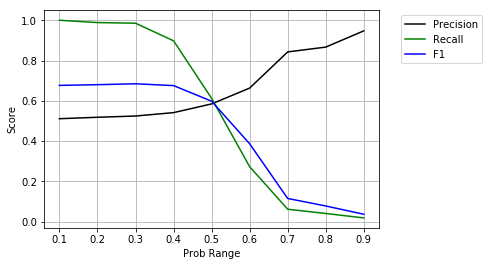

In [19]:
model_eval(X_rus_resampled_test, y_rus_resampled_test, logreg)
graph_eval(X_rus_resampled_test, y_rus_resampled_test, logreg)